# 뉴스 그룹 분류 경진대회 베이스라인

이번 대회는 영어 뉴스 데이터를 통해 뉴스 그룹을 분류하는 대회입니다.

스포츠, 사회, 과학, 정치, 종교 등 20개의 카테고리의 토픽을 분류하는 간단한 대회 처럼 보이지만,   
자연어 처리를 처음 접하는 분들에게는 어디부터 시작해야 하는지 막막하실 겁니다.

베이스라인을 통해 자연어 처리 기초에 입문해보세요!

# 데이터 불러오기

먼저 분석하려는 데이터를 작업장으로 가져오는 작업이 필요합니다.

이를 위해서 파이썬 라이브러리 중 하나인 Pandas를 이용합니다.

pandas 라이브러리는 엑셀과 같은 행과 열로 이루어진 테이블(table) 형식의 데이터를 편하게 다루도록 해주는 라이브러리입니다.

데이터 분석에는 반드시 사용된다고 해도 과언이 아닌 라이브러리이니, 시간이 날때마다 공부해둡시다.

In [5]:
import pandas as pd

#csv 형식의 training 데이터를 로드합니다.
train = pd.read_csv('data/train.csv')

#데이터 살펴보기 위해 데이터 최상단의 5줄을 표시합니다.
train.head() 

,id,text,target
0,0,"\nThey were, and even if Washington might cons...",10
1,1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,2,\n\n\nNot to worry. The Masons have been demo...,19
3,3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,4,Help: I am running some sample problems from O...,5


In [6]:
train.shape

(9233, 3)

# 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [7]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


이제 본격적으로 모델을 설계하기 위해 데이터를 문서와 label 로 나누어 줍니다

In [8]:
X = train.text #training 데이터에서 문서 추출
y = train.target #training 데이터에서 라벨 추출

In [9]:
X.head() #데이터 살펴보기

0    \nThey were, and even if Washington might cons...
1    We run "SpaceNews & Views" on our STAREACH BBS...
2    \n\n\nNot to worry.  The Masons have been demo...
3    Only Brendan McKay, or maybe ARF, would come t...
4    Help: I am running some sample problems from O...
Name: text, dtype: object

In [10]:
y.head() #데이터 살펴보기

0    10
1    14
2    19
3    17
4     5
Name: target, dtype: int64

# CountVectorizer 의 이해

컴퓨터는 일반적으로 문장(텍스트)을 계산할 수 없고 숫자형 피처를 데이터로 입력받아 동작하기 때문에 

텍스트와 같은 데이터는 머신러닝 알고리즘에 바로 입력할 수가 없습니다. 

따라서 컴퓨터가 계산을 하기 위해서는 먼저 문장을 숫자형 값으로 바꾼 다음 계산하도록 해야 합니다.

이것을 워드 임베딩(word embedding)이라고 합니다.

이번 베이스라인에서는 CountVectorizer 기법을 사용해 문장을 숫자로 표현해보겠습니다.

CountVectorizer 는 입력된 문장을 토큰화(Tokenize)하여 토큰의 등장 빈도 벡터로 바꿔주는 기법입니다.

토큰화란 문장를 의미가 있는 최소의 단위로 쪼개는 것을 의미합니다.

예를 들어 "hello, I am a data scientist!" 라는 문장을 띄어쓰기 기준으로 토큰화 시키면

"hello", ",", "I", "am", "a", "data", "scientist", "!" 라는 8개의 토큰으로 토큰화 됩니다.

토큰화를 하는 방식은 여러가지가 있지만 이번 베이스라인에서는 띄어쓰기를 기준으로 토큰화를 진행해보겠습니다.

CountVectorizer 사용을 위해 sklearn 패키지에 있는 CountVectorizer 를 불러옵니다.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer #sklearn 패키지의 CountVectorizer import

sample_vectorizer = CountVectorizer() #객체 생성

이제 CounterVectorizer 를 학습 시켜주어야 합니다.

어떠한 단어들을 사용할 지, 어떠한 단어가 중요도를 가지는지 학습하는 과정입니다.

CountVectorizer 의 경우 단어의 출현 빈도를 기준으로 문장을 벡터(=숫자의 집합)로 바꿔줍니다.

In [12]:
sample_text1 = ["hello, my name is dacon and I am a data scientist!"]

sample_vectorizer.fit(sample_text1) #CountVectorizer 학습

CountVectorizer()

이제 학습이 완료되었습니다.

먼저 sample_vectorizer 가 학습한 단어 목록을 확인해보겠습니다.

이를 Vocabulary라고 하며, 앞으로 sample_vectorizer는 이 Vocab을 기준으로 새로운 문장을 숫자로 바꿔줄 것입니다.




In [13]:
print(sample_vectorizer.vocabulary_) #Vocabulary

{'hello': 4, 'my': 6, 'name': 7, 'is': 5, 'dacon': 2, 'and': 1, 'am': 0, 'data': 3, 'scientist': 8}


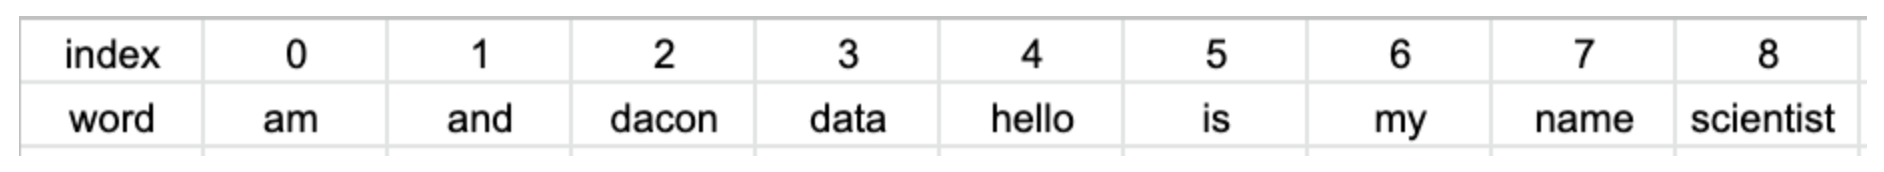

"hello, my name is dacon and I am a data scientist" 문장으로 vectorizer 를 학습 시켰습니다.

sklearn의 CountVectorizer는 "I", "a" 와 같이 길이가 2 이하인 단어들과, ",", !" 같은 특수 문자를 의미가 적다고 판단하여 제외시킵니다.

그래서 최종적으로는 9개의 단어들이 Vocab 에 포함되어있습니다.

그럼 이제 다른 문장을 sample_vectorizer 를 활용해 벡터로 transform 해볼까요?

In [14]:
sample_text2 = ["you are learning dacon data science"]

sample_vector = sample_vectorizer.transform(sample_text2)
print(sample_vector.toarray())

[[0 0 1 1 0 0 0 0 0]]


"you are learning dacon data science" 문장을 sample_vectorizer 를 활용해 transform 해보았습니다.

단어들의 출현 빈도로 이루어진 크기 9의 백터가 출력되었습니다. 이 벡터를 BoW 라고 합니다.

BoW 란 "Bag of Words" 의 약자로 CountVectorizer 로 변환된 단어의 집합을 말합니다

특정 단어가 N번 등장했다면, 그 특정 단어가 N개가 들어있습니다. 

또한 단어를 섞었기 때문에 더 이상 단어의 순서는 중요하지 않습니다.

BoW를 만드는 과정은 이렇게 두 가지 과정이 있습니다.

(1) 우선 각 단어에 고유한 정수 인덱스를 부여합니다.

(2) 각 인덱스의 위치에 단어 토큰의 등장 횟수를 기록한 벡터를 만듭니다.

sample_text2 문장 내에는 "dacon", "data" 단어가 각 1번 씩 출현했습니다.

따라서 "dacon" 과 "data" 에 해당하는 인덱스의 값이 1로 표시되어 있고, 등장하지 않은 단어들은 0으로 표시되어 있습니다.

In [15]:
sample_text3 = ["you are learning dacon data science with news data"]

sample_vector2 = sample_vectorizer.transform(sample_text3)
print(sample_vector2.toarray())

[[0 0 1 2 0 0 0 0 0]]


"you are learning dacon data science with news data" 문장에는 "dacon" 단어가 1번, "data" 단어가 2번 출현했습니다.

따라서 "dacon" 단어에 해당하는 인덱스에는 1의 값이, "data" 에 해당하는 인덱스에는 2의 값이 할당되었습니다.

CountVectorizer 는 위와 같이 작동합니다.

이해를 위해 CountVectorizer 를 하나의 문장을 사용해 학습 시켰기에 생성된 Vocab과 BoW 의 크기는 모두 9 였습니다.

하지만 더 큰 데이터를 사용해 CountVectorizer 를 학습시킨다면 Vocab과 Bow 의 크기는 더욱 증가할 것입니다.

이처럼 BoW는 각 단어가 등장한 횟수를 수치화하는 텍스트 표현 방법이기 때문에, 

주로 어떤 단어가 얼마나 등장했는지를 기준으로 문서가 어떤 성격의 문서인지를 판단하는 작업에 쓰입니다. 

즉, 분류 문제나 여러 문서 간의 유사도를 구하는 문제에 주로 쓰입니다.

그럼 뉴스 그룹 데이터를 분석해봅시다.

# 뉴스 그룹 데이터

먼저 새로운 객체를 생성하여 CountVectorizer 를 할당해 줍니다.

다음 미리 준비해두었던 데이터를 사용해 CountVectorizer 를 학습 시켜줍니다.

In [16]:
vectorizer = CountVectorizer() #countvectorizer 생성
vectorizer.fit(X) #countvectorizer 학습
X = vectorizer.transform(X) #transform

이제 CountVectorizer 를 학습 시켰습니다.

X 는 이제 자연어가 아닌 숫자형 백터 데이터로 이루어져 있습니다.

이제는 머신러닝 모델의 input 값으로 적절한 데이터의 형식을 갖춘 것입니다!

역변환을 통하여 문장의 단어들을 확인할 수도 있습니다.

In [17]:
vectorizer.inverse_transform(X[0]) #역변환하여 첫번째 문장의 단어들 확인

[array(['and', 'been', 'bust', 'complete', 'consider', 'druce', 'even',
        'goals', 'has', 'here', 'if', 'in', 'might', 'minute', 'only',
        'patty', 'rework', 'that', 'they', 'trade', 'utter', 'washington',
        'were'], dtype='<U81')]

# Logistic Regression

분류 문제를 효과적으로 잘 처리할 수 있는 알고리즘은 로지스틱 회귀, 선형 서포트 벡터 머신, 나이브 베이즈 등이 있습니다.

이중에서 LogisticRegression 모델을 사용하여 뉴스의 토픽을 분류해보겠습니다.

예측하고자 하는 것이 연속적인 값을 갖는 수치 형태가 아닌, 1 단위로 끊어지는 분류 문제이기 때문에

category를 분류할 때 사용하는 LogisticRegression을 이용하여 진행하도록 하겠습니다.

In [18]:
from sklearn.linear_model import LogisticRegression #모델 불러오기
model = LogisticRegression(max_iter=500) #객체에 모델 할당
model.fit(X, y) #모델 학습

LogisticRegression(max_iter=500)

이제 모델 학습이 완료되었습니다!

모델이 잘 학습되었는지 X의 첫번쨰 문장을 모델에 넣어보도록 하겠습니다.

In [19]:
from sklearn.metrics import accuracy_score

#run model
y_pred = model.predict(X[0])
print('예측 라벨 : ', y_pred)
print('실제 라벨 : ', train.target[0])

예측 라벨 :  [10]
실제 라벨 :  10


X의 첫번째 문장은 10번 카테고리 그룹으로 잘 학습되어 분류된 것을 확인해 볼 수 있습니다.

# Dacon 대회 제출

이제 test 데이터를 예측해 제출 파일을 생성해 봅시다.

In [21]:
test = pd.read_csv("data/test.csv") #파일 읽기
test.head() #파일 확인

,id,text,target
0,0,\nThe VL-IDE Adapter can be much faster then t...,3
1,1,\n\nYeah. In a fire that reportedly burned ho...,19
2,2,":Judge: ""I grant you immunity from whatever ma...",11
3,3,"I, too, put a corbin seat on my Hawk. I got t...",8
4,4,\n\nDo I ever!!!!!! After 2 years of having h...,13


이제 test 데이터를 transform 합니다. 그 후 test 데이터의 label 을 예측합니다.

In [22]:
test_X = test.text #문서 데이터 생성

test_X_vect = vectorizer.transform(test_X) #문서 데이터 transform 
#test 데이터를 대상으로 fit_transform 메소드를 실행하는 것은 test 데이터를 활용해 vectorizer 를 학습 시키는 것으롤 data leakage 에 해당합니다.

pred = model.predict(test_X_vect) #test 데이터 예측
print(pred)

[ 3 16 11 ...  4  0  7]


In [27]:
submission = pd.read_csv("./sample_submission.csv") #제출용 파일 불러오기
submission.head() #제출 파일이 잘 생성되었는지 확인

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [28]:
submission["target"] = pred #예측 값 넣어주기
submission.head() # 데이터가 잘 들어갔는지 확인합니다.

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,13


In [ ]:
# submission을 csv 파일로 저장합니다.
# index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다. 
# 정확한 채점을 위해 꼭 index=False를 넣어주세요.
submission.to_csv("./submission.csv",index=False)

이렇게 생성된 submission.csv 파일을 데이콘 대회 페이지에 업로드 & 제출하여 결과를 확인하세요.

축하합니다! 자연어 처리를 완료하셨습니다! 자연어 처리의 첫걸음을 떼신 것을 축하드립니다.

앞으로도 데이콘과 함께 즐겁게 데이터 분석 능력을 키워가시면 좋겠습니다.

감사합니다.